### Question 2

Epoch 10/100, Loss: 0.0664
Epoch 20/100, Loss: 0.0371
Epoch 30/100, Loss: 0.0110
Epoch 40/100, Loss: 0.0070
Epoch 50/100, Loss: 0.0047
Epoch 60/100, Loss: 0.0032
Epoch 70/100, Loss: 0.0023
Epoch 80/100, Loss: 0.0019
Epoch 90/100, Loss: 0.0016
Epoch 100/100, Loss: 0.0014
Length of Predictions: 335
Length of Actual Test Values: 335
Test Loss on New Dataset (MSE): 0.0087
Mean Absolute Error (MAE): 0.0705
Root Mean Squared Error (RMSE): 0.0932


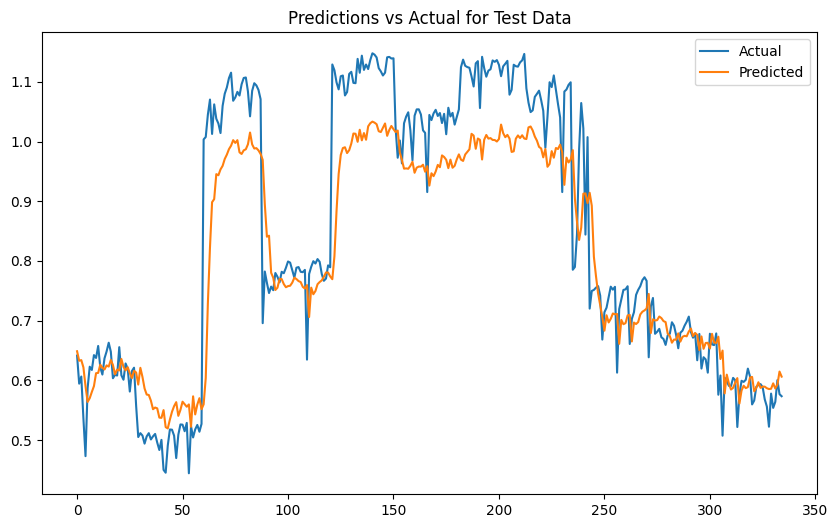

In [119]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load the original dataset (final_dataset.csv)
df = pd.read_csv("final_dataset.csv")
df = df.rename(columns={"Unnamed: 0": "Date"})

# Convert 'Date' to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Group by date and aggregate data
df_grouped = df.groupby('Date').agg({
    'avg_tripduration': 'mean',
    'total_trips': 'sum',
    'unique_start_stations': 'sum',
    'unique_end_stations': 'sum',
    'usertype_Customer': 'sum',
    'usertype_Subscriber': 'sum'
})

# Handle NaN values in df_grouped
df_grouped = df_grouped.dropna()

# Separate target variable (y) from features (X)
X = df_grouped.drop(columns=['total_trips'])  # All features except 'total_trips'
y = df_grouped['total_trips']  # Target variable

# Scale the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Convert the scaled features into a DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=df_grouped.index)

# Prepare sequences for RNN
def create_sequences(data, target_col, sequence_length=30):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        sequence = data[i:i + sequence_length, :]  # Extract sequence
        X.append(sequence)  # All features
        y.append(data[i + sequence_length, target_col])  # Target column
    return np.array(X), np.array(y)

# Create sequences
target_col_index = df_grouped.columns.get_loc('total_trips')
X_seq, y_seq = create_sequences(X_scaled_df.values, target_col_index)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_seq, dtype=torch.float32)
y_tensor = torch.tensor(y_seq, dtype=torch.float32)

# Check if using a GPU and move tensors to device (optional)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_tensor = X_tensor.to(device)
y_tensor = y_tensor.to(device)

# RNN Model Definition
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out, _ = self.rnn(x)  # RNN forward pass
        out = out[:, -1, :]  # Get the last time step's output
        out = self.fc(out)   # Fully connected layer
        return out

# Hyperparameters
input_size = X_tensor.shape[2]  # Number of features in each time step
hidden_size = 50  # Number of hidden units
output_size = 1  # We are predicting one value (total_trips)
num_layers = 1  # Number of RNN layers
learning_rate = 0.001
num_epochs = 100  # Number of epochs for training

# Initialize the model, loss function, and optimizer
model = RNN(input_size, hidden_size, output_size, num_layers)
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()

    # Forward pass
    outputs = model(X_tensor)  # Passing tensors to the model
    loss = criterion(outputs.squeeze(), y_tensor)  # Squeeze to match dimensions
    
    optimizer.zero_grad()  # Zero the gradients
    loss.backward()  # Backpropagate the error
    optimizer.step()  # Update the weights
    
    # Print the loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}')

# Now, load the test dataset (test.csv)
df_test = pd.read_csv("2023.csv")
df_test = df_test.rename(columns={"Unnamed: 0": "Date"})

# Preprocess the test data
df_test['Date'] = pd.to_datetime(df_test['Date'])
df_test.set_index('Date', inplace=True)

# Group by date and aggregate data
df_test_grouped = df_test.groupby('Date').agg({
    'avg_tripduration': 'mean',
    'total_trips': 'sum',
    'unique_start_stations': 'sum',
    'unique_end_stations': 'sum',
    'usertype_Customer': 'sum',
    'usertype_Subscriber': 'sum'
})

# Handle NaN values in test data
df_test_grouped = df_test_grouped.dropna()

# Separate target variable (y) from features (X) for the test dataset
X_test = df_test_grouped.drop(columns=['total_trips'])  # All features except 'total_trips'
y_test = df_test_grouped['total_trips']  # Target variable

# Scale the new test data using the same scaler
X_test_scaled = scaler.transform(X_test)

# Ensure test dataset has enough rows for sequence generation
sequence_length = 30
if len(df_test_grouped) <= sequence_length:
    raise ValueError("Test data is too short for the sequence length")

# Prepare sequences for the test data
X_test_seq, y_test_seq = create_sequences(X_test_scaled, target_col_index)

# Convert to PyTorch tensors
X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_seq, dtype=torch.float32).to(device)

# Evaluate the model on the new test dataset
model.eval()
with torch.no_grad():
    predictions_test = model(X_test_tensor).squeeze()

    # Ensure the length of predictions and actual test values match
    print(f"Length of Predictions: {len(predictions_test)}")
    print(f"Length of Actual Test Values: {len(y_test_tensor)}")

    # Check if lengths are consistent before calculating loss
    if len(predictions_test) == len(y_test_tensor):
        test_loss = criterion(predictions_test, y_test_tensor)
        print(f'Test Loss on New Dataset (MSE): {test_loss.item():.4f}')

        # Calculate MAE
        mae = torch.mean(torch.abs(predictions_test - y_test_tensor))
        print(f'Mean Absolute Error (MAE): {mae.item():.4f}')
        
        # Calculate RMSE
        rmse = torch.sqrt(torch.mean((predictions_test - y_test_tensor) ** 2))
        print(f'Root Mean Squared Error (RMSE): {rmse.item():.4f}')

        # Optionally, plot predictions vs actual values on the test set
        plt.figure(figsize=(10, 6))
        plt.plot(y_test_tensor.cpu().numpy(), label='Actual')
        plt.plot(predictions_test.cpu().numpy(), label='Predicted')
        plt.legend()
        plt.title('Predictions vs Actual for Test Data')
        plt.show()
    else:
        print("Length mismatch: Check sequence creation or test data length")


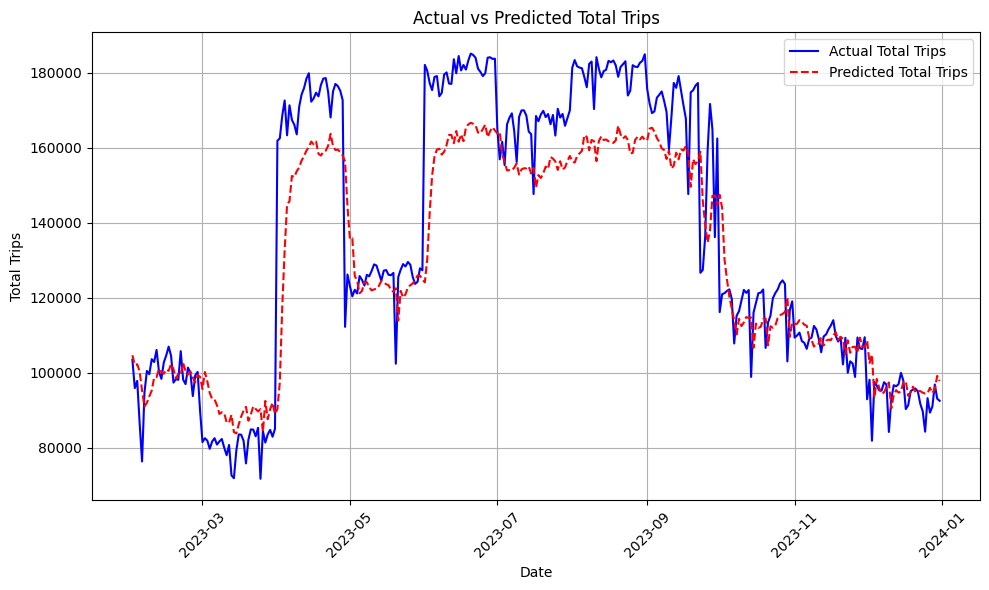

In [123]:
# Initialize a separate scaler for the target variable (total_trips)
target_scaler = MinMaxScaler()
y_scaled = target_scaler.fit_transform(y.values.reshape(-1, 1))  # Scale the target variable

# Now, create sequences with the target scaled
X_seq, y_seq = create_sequences(X_scaled_df.values, target_col_index)

# Inverse transform the actual and predicted values back to the original scale using the target scaler
y_test_rescaled = target_scaler.inverse_transform(y_test_seq.reshape(-1, 1))  # Rescale actual values
predictions_rescaled = target_scaler.inverse_transform(predictions_test.cpu().numpy().reshape(-1, 1))  # Rescale predicted values

# Plot predictions and actual values against the corresponding dates
test_dates = df_test_grouped.index[-len(y_test_rescaled):]  # Get the corresponding dates for the test set

plt.figure(figsize=(10, 6))
plt.plot(test_dates, y_test_rescaled, label='Actual Total Trips', color='blue', linestyle='-')
plt.plot(test_dates, predictions_rescaled, label='Predicted Total Trips', color='red', linestyle='--')

plt.title('Actual vs Predicted Total Trips')
plt.xlabel('Date')
plt.ylabel('Total Trips')
plt.legend()
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.grid(True)
plt.tight_layout()
plt.show()
